In [1]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import getpass
import time
import os.path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Load the database connection details
_data = np.load('data/db_details.npy', allow_pickle=True).tolist()
db_details = _data['db_details']
user = db_details['user']
host = db_details['host']
port = db_details['port']
dbname = db_details['dbname']
schema = db_details['schema']
    
# Connect to the database
conn = psycopg2.connect(dbname=dbname, user=user, host=host, port=port, password=getpass.getpass(prompt='Password:'.format(user)))
cur = conn.cursor()
cur.execute('SET search_path TO {}'.format(schema))
conn.commit()

Password: ··········


In [3]:
# Load the SQL queries
_data = np.load('queries/static_queries.npy', allow_pickle=True).tolist()
SQL_queries = _data['static_queries']
print("Loaded the SQL queries...")

# Load the patient data
_data = np.load('data/final_patients.npy', allow_pickle=True).tolist()
patients = _data['patients']
print("... and the patient data!")

Loaded the SQL queries...
... and the patient data!


In [4]:
# Function to query the database for a specific feature
def get_feature(feature_name, column_names):
    
    '''
    Queries the MIMIC-III database for the specified feature.
    SQL_queries is a dictionary with feature names as keys, and the corresponding SQL queries as values.
    '''
    
    start = time.time()

    # Query the database
    query = SQL_queries[feature_name]

    # Execute the query and fetch the result
    cur.execute(query)
    conn.commit()
    data = cur.fetchall()

    # Store the result of the query as a pandas dataframe
    result = pd.DataFrame(data, columns=column_names)

    end = time.time()
    
    # Print run time
    print("The '{}' query took {} seconds".format(feature_name, round((end-start),2)))
    
    # Return the feature
    return result

In [5]:
# Function that creates a list of numpy arrays with all measurements for each patient sorted by time
def collect_all_measurements(feature, patients):
    '''
    Creates a numpy array, where each row is an admission and each column is a binary variable (either admission type or aids/haem/mets).
    feature is a pandas DataFrame representing some feature queried from the MIMIC-III database
    patients is a pandas DataFrame that has been previously loaded, containing patient details for patients of interest
    '''
    
    start = time.time()
    
    # Extract hospital admission ID
    m = len(patients) # number of patients
    hadm_id = patients['hadm_id']
    
    # Create an empty array in which to store the data
    results = np.zeros((m,3))
    
    # Iterate over every patient
    for i in range(m):
    
        # Define subject ID
        h_id = int(hadm_id.iloc[i])
    
        # Select data for this subject
        measurements = feature[feature['hadm_id']==h_id]
        
        # Convert to a numpy array
        res = np.sum(np.array(measurements.iloc[:,-3:]), axis=0) # some admissions are defined as both medical and surgical
        
        # Append this subjects' array to the results list (after casting to a numpy array)
        results[i,:] = res
        
    end = time.time()
    
    # Print run time
    print("It took {} seconds to collect all the measurements for each patient".format(round((end-start),2)))
        
    # Return the results
    return results

In [6]:
# Define column names for the two features
column_names = {
    'admission_type': ["hadm_id", "firstadmitflag", "scheduledsurgical", "unscheduledsurgical", "medical"], 
    'aids_haem_mets': ["hadm_id", "aids", "haem", "mets"]
}

# Iterate over every feature
for i in SQL_queries:
    
    # Define a pre-cursor variable name
    precursor = '_' + i
    
    # Query the database for the feature
    exec(precursor + " = get_feature('{}', {})".format(i, column_names[i]))
    
    # Collect measurements for every patien
    exec(i + " = collect_all_measurements({}, patients)".format(precursor))
    
    # Print a separator between features
    print('')

The 'admission_type' query took 0.49 seconds
It took 5.23 seconds to collect all the measurements for each patient

The 'aids_haem_mets' query took 2.06 seconds
It took 4.98 seconds to collect all the measurements for each patient



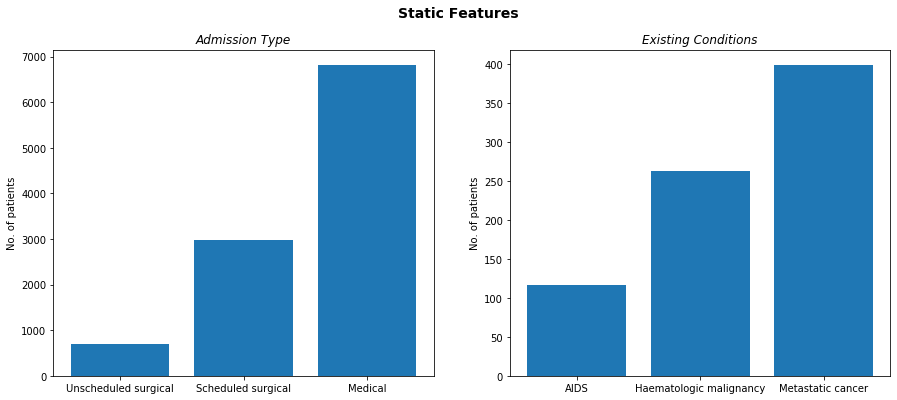

In [7]:
# Visualise the data
fig, axs = plt.subplots(1, 2, figsize=(15,6))
fig.suptitle('Static Features', weight='semibold', fontsize=14)

# Plot the admission type
axs[0].bar(x=['Unscheduled surgical', 'Scheduled surgical', 'Medical'], height=np.sum(admission_type, axis=0))
axs[0].set_title('Admission Type', style='italic')
axs[0].set_ylabel('No. of patients')

# Plot the AIDS/haem/mets status
axs[1].bar(x=['AIDS', 'Haematologic malignancy', 'Metastatic cancer'], height=np.sum(aids_haem_mets, axis=0))
axs[1].set_title('Existing Conditions', style='italic')
axs[1].set_ylabel('No. of patients');

In [8]:
# Age, mortality, gender and extubation failure can be taken straight from patient details
age = np.array(patients['age'], dtype=float)
gender = np.array(patients['gender']=='F')*1.0
mortality = np.array(patients['hospital_expire_flag'])
extubation_failure = np.array(patients['weaning_failure'])*1.0
reint_5d = np.array(patients['reintubated_after_5_days'])*1.0

In [9]:
# Save to static_features.npy
if not os.path.exists('./data'):
    os.makedirs('./data')

tosave = {
    '_admission_type': _admission_type, 'admission_type': admission_type,
    '_aids_haem_mets': _aids_haem_mets, 'aids_haem_mets': aids_haem_mets,
    'age': age,
    'gender': gender,
    'mortality': mortality,
    'extubation_failure': extubation_failure,
    'reint_5d': reint_5d
}
np.save('data/static_features.npy',tosave)
print("Saved!")

Saved!
